### Names:
Mackenzie Campbell, Kaylee Chung Young Cheong, Nicole Nielsen, Yale Wang

# Investigating the relationship between number of tennis seasons played and professional tennis players’ current rank

## Introduction:

Sports are becoming increasingly data-driven, and proper analysis of this data can allow for better prediction of game and tournament results. In particular, professional tennis circuits amass large datasets that contain information about each player such as age, current rank, number of seasons played, height, and weight [1].

The goal of this project was to improve the prediction of professional tennis players’ current world rank. We aimed to answer the question: “how does the number of seasons played by professional tennis players correlate with their current world rank, and can the number of seasons played by a new player be used to accurately predict their rank?”

We decided to focus on rank and the number of seasons played because our initial preliminary data exploration indicated a potential correlation between these two variables. This prompted us to investigate if this relationship could be translated into an effective predictive model of rank based on the number of seasons played by a top tennis player. Furthermore, number of seasons played was chosen as our predictor variable instead of purely age, since research shows that “training age” (i.e. how long an athlete has been training for their sport) impacts when an athlete will reach their peak performance [2].

When plotting rank vs. seasons played, we expected to find a non-linear relationship between the variables. In the early years, we expected rank to decrease (i.e. move up the rankings toward no. 1), as players become more skilled and experienced. However, we expected rank to level off after a certain number of years and potentially increase again. As tennis is a strenuous sport, we assume that as athletes age past their physical prime, it becomes more likely for them to sustain a career ending injury, start a family which may alter their priorities, or become unable to keep up with the physical demand of the sport due to the inevitable wear and tear on the body.

In order to answer our question, we analysed a dataset of the top 500 tennis players in the world from UltimateTennisStatistics.com. The dataset contains various statistics on top tennis players in the world, including names, ages, countries, how many seasons they have played, and overall rank. This allowed us to create a model to predict the rank of a new player based on the number of seasons they have played. 


## Methods and Results:

As seen in the summary table (table 1), the average number of seasons played by professional tennis players in this dataset is 6.44, with a standard deviation of 4.97. Unfortunately, this value was missing for 95 players, so they were excluded from analysis, leaving 277 players in the dataframe.

We began by loading the necessary packages, then loading the dataset from UltimateTennisStatistics.com. The dataset was wrangled into a tidy format by separating columns containing multiple variables, tidying column names, removing unnecessary brackets from values, and finally ensuring each column had values of the correct data type.

After using the `ggpairs()` function to visualize the variables plotted against each other, we chose to focus our investigation on the variables “current rank” and “seasons”. We selected the columns rank and the number of seasons each player played, dropping unnecessary columns such as 'Facebook', 'Wikipedia', and 'Nicknames'. Our dataframe now consisted of only these two columns.

We then moved on to the KNN regression algorithm. This regression algorithm was selected as it allows for non-linear relationships, as opposed to linear regression. After splitting the dataset into training and testing data, we created a recipe to standardize the data. This was important, as the two variables are on very different scales. Current rank ranges from 1-500, whereas seasons only ranges from 1-22. We created the model specification to tune the number of nearest neighbors used (“K”), and put these together in a workflow. Using a 5-fold split of the training data (into training and validation sets) we performed cross-validation. By assessing the RMSE values, we found that using K = 34 resulted in the highest accuracy.

After retraining our model with a new workflow using K = 34, we predicted the current rank of players in the testing data and found the root mean squared prediction error (RMSPE) to be 123.6. Finally, we visualized the results by plotting the model as a line plot over both the training and testing data as scatterplots to visually observe the accuracy of the model to the points (see figures 2 and 3). 

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(stringi)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Step 1: reading and tidying the data**

In [25]:
#loading dataset
players_url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
player_stats <- read_csv(players_url)

#tidying column names
names(player_stats) <- gsub(" ", "_", names(player_stats)) %>%
                        tolower()

#tidying "active" column
player_stats$active[is.na(player_stats$active)] <- "No"

tidy_player <- player_stats %>%
        
    #separating columns with multiple variables
        separate(age, sep = " ", into = c("age", "birthdate"), convert = TRUE) %>%
                        
        separate(current_rank, sep = " ", into = c("current_rank", "current_rating"), convert = TRUE) %>%
        separate(best_rank, sep = " ", into = c("best_rank", "best_rank_date"), convert = TRUE) %>%
                        
        separate(favorite_surface, sep = " ", into = c("favorite_surface", "favorite_surface_percent")) %>%
        
        separate(current_elo_rank, sep = " ", into = c("current_elo_rank", "current_elo_rating"), convert = TRUE) %>% 
        separate(best_elo_rank, sep = " ", into = c("best_elo_rank", "best_elo_rank_date"), convert = TRUE) %>%

        separate(peak_elo_rating, sep = " ", into = c("peak_elo_rating", "peak_elo_rating_date"), convert = TRUE) %>%

        separate(goat_rank, sep = " ", into = c("goat_rank", "goat_rating"), convert = TRUE) %>%

    #further tidying (e.g. removing brackets, changing data type)
        mutate(current_rating = parse_number(current_rating), 
                best_rank_date = str_replace(best_rank_date, "[(]", ""), best_rank_date = str_replace(best_rank_date, "[)]", ""), best_rank_date = as.Date(best_rank_date, format = '%d-%m-%Y'),
                height_cm = parse_number(height), weight_kg = parse_number(weight), prize_money = parse_number(prize_money), 
                current_elo_rating = parse_number(current_elo_rating),
                best_elo_rank_date = str_replace(best_elo_rank_date, "[(]", ""), best_elo_rank_date = str_replace(best_elo_rank_date, "[)]", ""), best_elo_rank_date = as.Date(best_elo_rank_date, format = '%d-%m-%Y'),
                peak_elo_rating_date = str_replace(peak_elo_rating_date, "[(]", ""), peak_elo_rating_date = str_replace(peak_elo_rating_date, "[)]", ""), peak_elo_rating_date = as.Date(peak_elo_rating_date, format = '%d-%m-%Y'),
                last_appearance = as.Date(last_appearance, format = '%d-%m-%Y'),
                goat_rating = parse_number(goat_rating),
                active = as.factor(active))                       
     
stats_summary <- tidy_player %>%
        select_if(is.numeric) %>%
        gather(factor_key = TRUE) %>%
        group_by(key) %>%
        summarise(mean = mean(value, na.rm = TRUE), sd = sd(value, na.rm = TRUE), min = min(value, na.rm = TRUE), max = max(value, na.rm = TRUE))
stats_summary

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.

Warning message:
“Expected 2 pieces. Additional pieces discarded in 41 rows [3, 5, 6, 20, 21, 53, 58, 66, 89, 119, 129, 141, 142, 152, 155, 165, 188, 193, 205, 212, ...].”
`summarise()` ungrouping output (override with `.groups` argument)



key,mean,sd,min,max
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
x1,2.495000e+02,1.444818e+02,0,499
age,2.596794e+01,4.455376e+00,16,40
current_rank,2.490283e+02,1.433827e+02,1,500
current_rating,4.540202e+02,9.189758e+02,58,10235
best_rank,1.781784e+02,1.357515e+02,1,488
prize_money,3.405563e+06,1.202347e+07,145,139144944
turned_pro,2.009252e+03,4.716612e+00,1997,2019
seasons,6.494652e+00,4.954346e+00,1,22
current_elo_rank,9.602174e+01,5.527348e+01,1,191


Table 1: Summary statistics of dataset. Shows mean, standard deviation, minimum, and maximum values for each variable.

In [19]:
#selecting columns to plot
tidy_player_stats <- tidy_player %>%
        select(current_rank, seasons) %>%
                        
        arrange(current_rank) %>%
        filter(!is.na(current_rank) & !is.na(seasons))

head(tidy_player_stats)

current_rank,seasons
<int>,<dbl>
1,19
2,17
3,22
4,5
5,10
6,4


Table 2: Tidied data with current rank and number of seasons played by professional tennis players.

**Step 2: Splitting into training and test data**

In [20]:
#setting the seed to ensure split is reproducible
set.seed(1)

stats_split <- initial_split(tidy_player_stats, prop = 0.75, strata = current_rank)
stats_training <- training(stats_split)
stats_testing <- testing(stats_split)

**Step 3: visualize training data by plotting current player rank vs. number of seasons played**

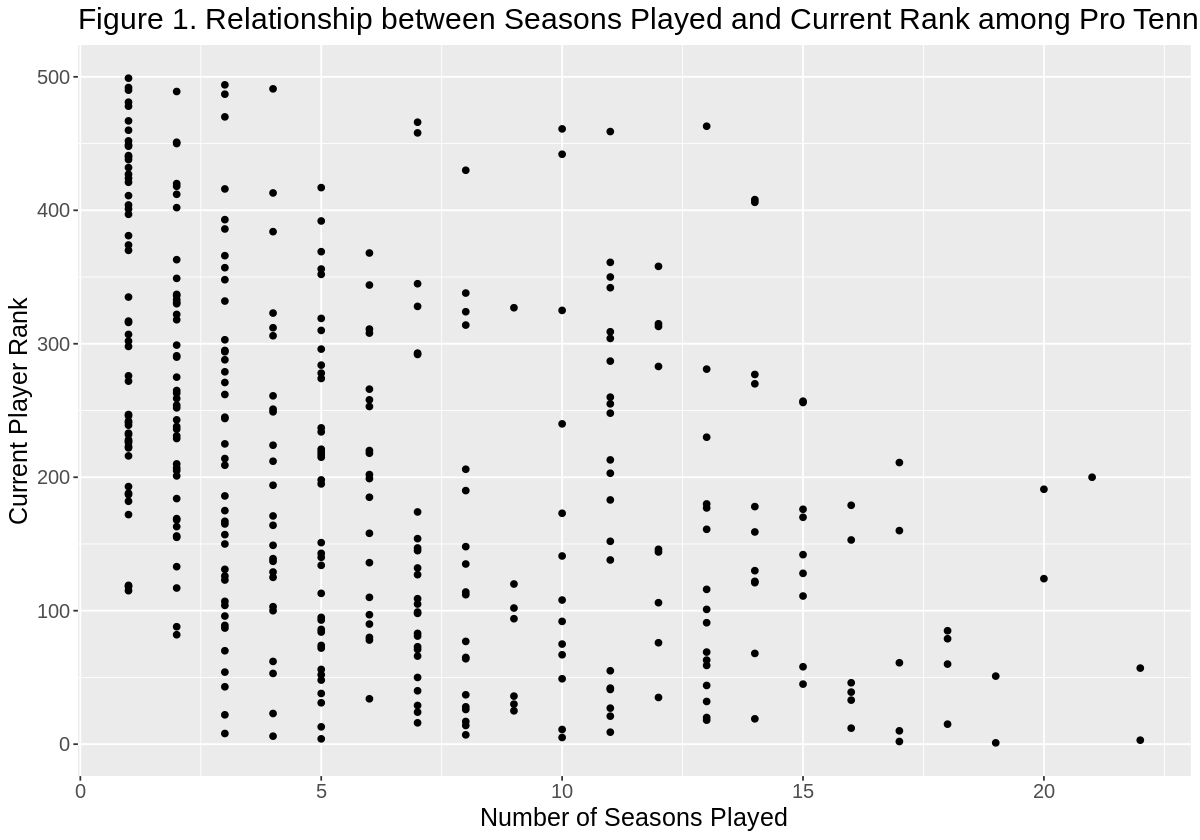

In [10]:
options(repr.plot.height = 7, repr.plot.width = 10)

rank_vs_seasons <- ggplot(tidy_player_stats, aes(x = seasons, y = current_rank)) +
        geom_point() +
        labs(x = "Number of Seasons Played", y = "Current Player Rank", title = "Figure 1. Relationship between Seasons Played and Current Rank among Pro Tennis Players") +
        theme(text = element_text(size = 15))
rank_vs_seasons

**Step 4: KNN regression**

In [6]:
#create the recipe to standardize the data
stats_recipe <- recipe(current_rank ~ seasons, data = stats_training) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

#split the training data into training and validation for a 5-fold cross-validation
stats_vfold <- vfold_cv(stats_training, v = 5, strata = current_rank)

#create the model specification to tune the number of nearest neighbors ("K")
stats_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("regression")

#identify which K values to test
gridvals <- tibble(neighbors = seq(1:50))

#put together in a workflow
stats_workflow <- workflow() %>%
        add_recipe(stats_recipe) %>%
        add_model(stats_tune)

#perform the cross-validation to choose the best K value
stats_tune_results <- stats_workflow %>%
        tune_grid(resamples = stats_vfold, grid = gridvals) %>%
        collect_metrics() %>%
        filter(.metric == "rmse") %>%
        arrange(mean) %>%
        slice(1)
stats_tune_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
34,rmse,standard,119.3712,5,1.603112,Model34


Table 3: Cross-validation results for most accurate K value (number of nearest neighbours).

In [26]:
#pull the best K value
neighbor_tune <- stats_tune_results %>%
        pull(neighbors) 

#respecify the model specification with this K value
stats_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = neighbor_tune) %>%
        set_engine("kknn") %>%
        set_mode("regression")

#retrain the model
stats_fit <- workflow() %>%
        add_recipe(stats_recipe) %>%
        add_model(stats_spec) %>%
        fit(data = stats_training)

#predict using the testing data
stats_predictions <- stats_fit %>%
        predict(stats_testing) %>%
        bind_cols(stats_testing)
head(stats_predictions)

.pred,current_rank,seasons
<dbl>,<int>,<dbl>
119.2941,1,19
122.6765,7,8
122.6765,14,8
221.9412,21,11
139.8235,33,16
168.7059,34,6


Table 4: Predicted rank (.pred) of tennis players in testing data.

In [27]:
#get RMSPE 
stats_summary <- stats_predictions %>%
        metrics(truth = current_rank, estimate = .pred)
stats_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,123.5772536
rsq,standard,0.1416793
mae,standard,100.2749361


Table 5: Accuracy (RMSPE) of predictions on testing data.

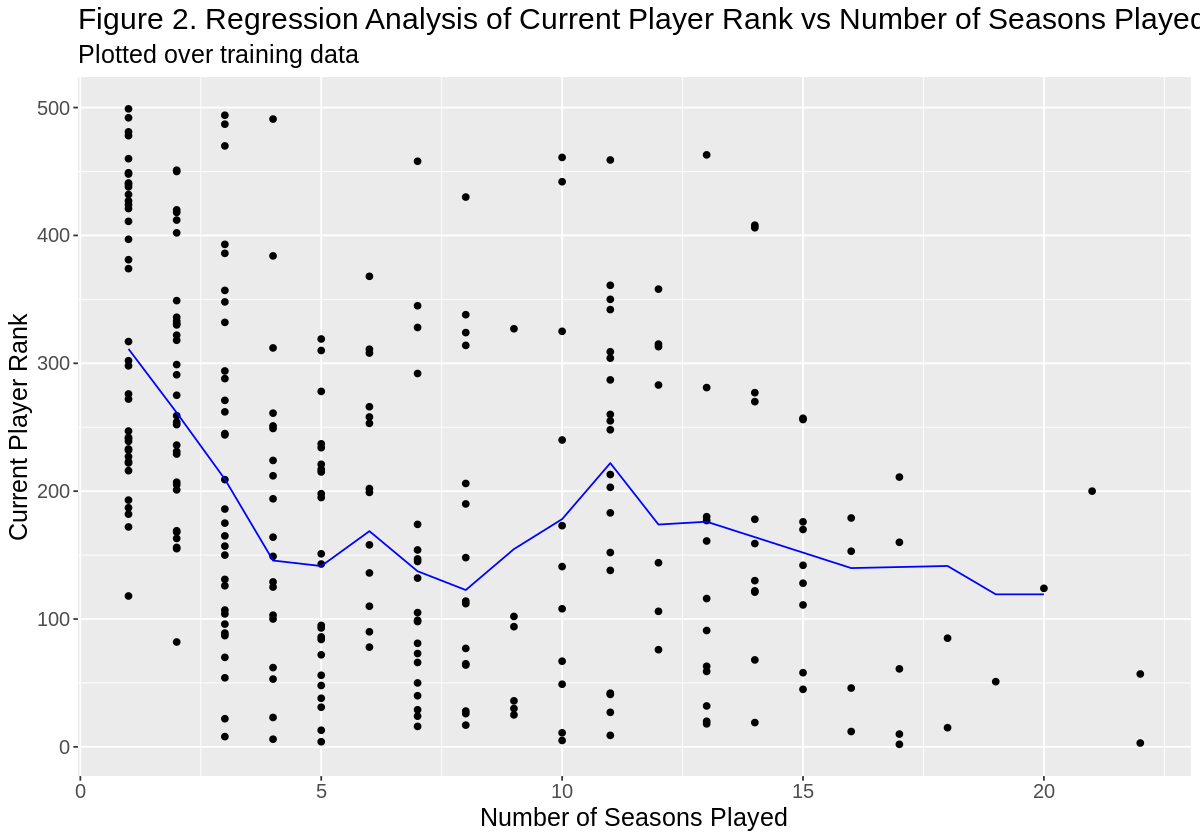

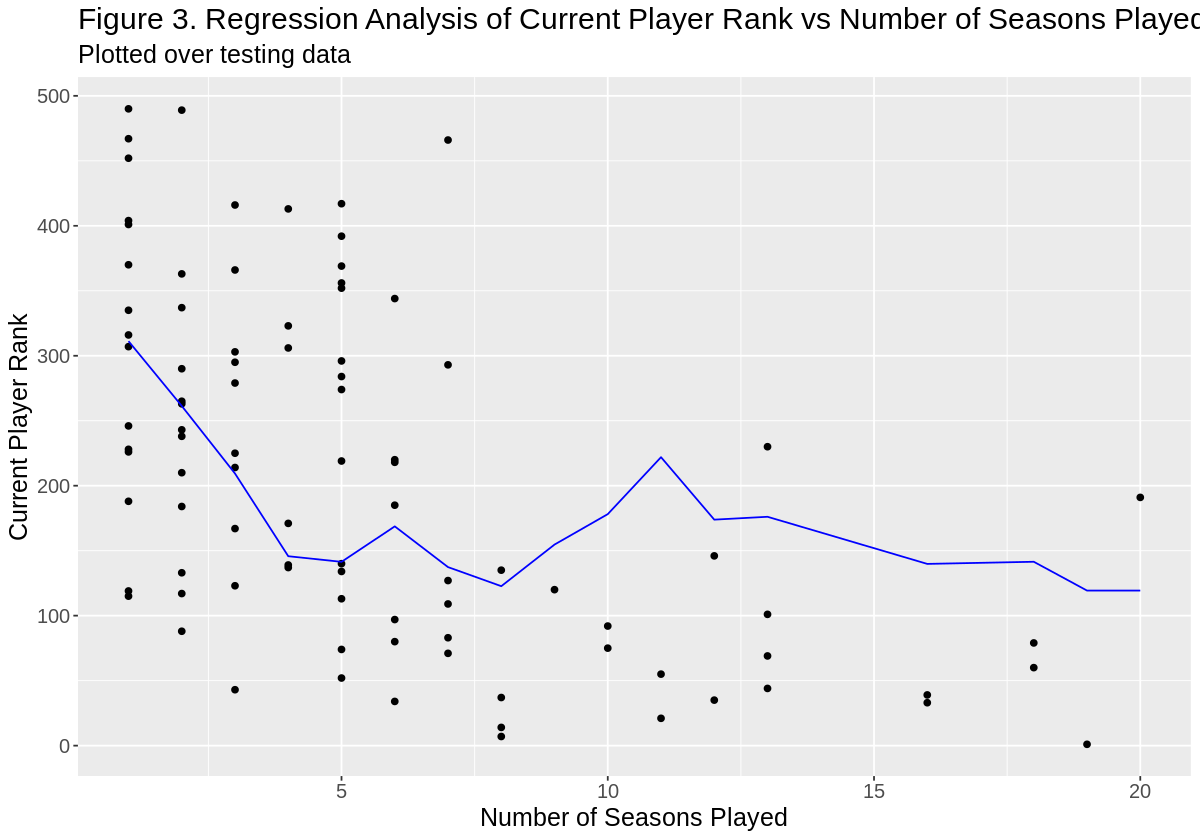

In [13]:
#plot model over training data
stats_plot <- ggplot(stats_training, aes(x = seasons, y = current_rank)) +
            geom_point() +
            geom_line(stats_predictions, mapping = aes(x = seasons, y = .pred), color = "blue") +
            labs(x = "Number of Seasons Played", y = "Current Player Rank", title = "Figure 2. Regression Analysis of Current Player Rank vs Number of Seasons Played", 
                 subtitle = "Plotted over training data") +
            theme(text = element_text(size = 15))
stats_plot

#plot model over testing data
stats_plot <- ggplot(stats_predictions, aes(x = seasons, y = current_rank)) +
            geom_point() +
            geom_line(stats_predictions, mapping = aes(x = seasons, y = .pred), color = "blue") +
            labs(x = "Number of Seasons Played", y = "Current Player Rank", title = "Figure 3. Regression Analysis of Current Player Rank vs Number of Seasons Played",
                subtitle = "Plotted over testing data") +
            theme(text = element_text(size = 15))

stats_plot

## Discussion:

Our findings and expected findings are relatively similar when illustrated on the scatterplot. We found that, generally, the more seasons played, the lower the number of the player’s rank- in this case, rank 1 is the best rank while rank 500 would be the lowest in the dataset. As seen in figures 2 and 3, this is a non-linear relationship, with rank drastically decreasing (improved performance) for the first 4 seasons, then plateauing or even increasing slightly.

However, there are some outliers, such as a player that has played ~12 seasons and remains in the 240 rankings. Outliers are to be expected in this kind of data, as there are many other factors that could possibly play a role in the success of a tennis player that could result in a player who has played many seasons still having a high rank or vice versa. Although these outliers have impacted our predictive model, we still find the data quite useful for a basic level of analysis, and there are many interesting conclusions that can be drawn from it. The data indicates that there is likely a correlation between the number of seasons of tennis played and the rank of a player. A player who has participated in more seasons- and therefore presumably has gained more experience- tends to have a lower number rank than players with fewer seasons played. However, there is only a weak correlation between the two data points, indicating that there likely are other factors impacting a tennis player’s rank besides the number of seasons played.

As seen in table 5, the root mean squared prediction error (RMSPE) of our model was determined to be 123.6 rank places. This is a large value, since the ranks only range from 1-500, with the RMSPE being 49.4% of the mean rank. A large error indicates our predictive model is quite inaccurate, as it only allows for prediction within 123.6 places. This is interesting, and suggests that the number of seasons played by professional tennis players on its own is not a good predictor of performance. There are many other factors that likely play a larger role in athletic performance, many of which are not available in the dataset used, such as total hours of practice, age, or even the player’s coach.

Additionally, studies have shown that various physical factors can affect a professional tennis player’s success, some of which cannot necessarily be changed or improved through playing in competitive tennis seasons or even through practice. This includes aerobic and cardiorespiratory capacity, physical strength, and flexibility [3].

Because many of these factors cannot be easily measured, particularly on a wide scale such as that needed for a predictive model such as the one we generated in this project, it is unlikely that an entirely accurate predictor for player rank could ever be created. However, our model utilizing the number of seasons played by professional players provides a partially effective starting point for such predictions.

Our findings, which model a players performance based on number of seasons played, can be significant in many areas of the sport, from deciding age classifications at tournaments to player coaching and career planning. Our predictive model may also be used to identify outliers in the tennis world. The data we produce can also serve as a prompt for further investigations, such as finding out why players peak after a certain amount of time and what factors shorten or lengthen a player’s career. Future studies may also investigate if athletes reach their peak after varying amounts of time across different sports or if genetics play a role in the length of an athlete’s career.


## References:

1. Player Stats for Top 500 Players (2022). Ultimate Tennis Statistics. www.ultimatetennisstatistics.com/
2. Haugen, Thomas & Sandbakk, Oyvind & Enoksen, Eystein & Seiler, Stephen & Tønnessen, Espen. (2021). Crossing the Golden Training Divide: The Science and Practice of Training World-Class 800-and 1500-m Runners. Sports Medicine. 10.1007/s40279-021-01481-2. 
3. Kovacs, M.S. (2006). Applied physiology of tennis performance. Br J Sports Med. 10.1136/bjsm.2005.023309
